In [1]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
import random
import yfinance as yf
import zipfile
import matplotlib.pyplot as plt
import datetime
import matplotlib.pyplot as plt

from tensorflow import keras
from matplotlib.dates import drange
from pandas import DataFrame
from pandas_datareader import data as pdr
from AlphaNetV3.src.alphanet import AlphaNet, AlphaNetV3, load_model
from AlphaNetV3.src.alphanet.data import TrainValData, TimeSeriesData
from AlphaNetV3.src.alphanet.metrics import UpDownAccuracy

In [2]:
yield_duration = 10 # 设置5, 10, 20日收益率
date_begin = 20160131 #这里可以改开始时间， 2015-2017年，1.31、4.30、7.31、10.31，2017年没有10.31

label_name = str(yield_duration) + "日回报率"
train_length = 800
val_length = 150
test_length = 150
gap_length = yield_duration
train_val_length = train_length + val_length + gap_length

model_att_name = './models_weights/' + str(yield_duration) + 'day/model_weights_att_' + str(date_begin) +'_' + str(train_length)
model_lstm_name = './models_weights/' + str(yield_duration) + 'day/model_weights_lstm_' + str(date_begin) + '_' + str(train_length)
model_gru_name = './models_weights/' + str(yield_duration) + 'day/model_weights_gru_' + str(date_begin) +'_' + str(train_length)

model_att = AlphaNet(l2=0.001, dropout=0.1, recurrent_unit='Transformer')
model_lstm = AlphaNetV3(l2=0.001, dropout=0, recurrent_unit='LSTM')
model_gru = AlphaNetV3(l2=0.001, dropout=0, recurrent_unit='GRU')

model_att.load_weights(model_att_name)
model_lstm.load_weights(model_lstm_name)
model_gru.load_weights(model_gru_name)

path_data_100 = "./data_100_" + str(yield_duration) + "day.csv"
data_all = pd.read_csv(path_data_100)
df = data_all
security_codes = df["代码"].unique()

for code in ['FB']: # 不用for循环，直接指定code就可以选定一支股票
    table_part = df.loc[df["代码"] == code, :]
    stock_data_list = []
    stock_data_list.append(TimeSeriesData(dates=table_part["日期"].values,                   # date column
                                          data=table_part.iloc[:, 3:].values,                # data columns
                                          labels=table_part[label_name].values)) # label column
    trainval_test_data = TrainValData(time_series_list=stock_data_list,
                              train_length=train_val_length,   # 1200 trading days for training
                              validate_length=test_length, # 150 trading days for validation
                              history_length=30,   # each input contains 30 days of history
                              sample_step=2,       # jump to days forward for each sampling
                              train_val_gap=gap_length     # leave a 10-day gap between training and validation
                             )
    train_val, test, dates_info = trainval_test_data.get(date_begin, order="by_date")
    # 下面是预测值，真实值在table_part["10日回报率"].values里面
    # 下面两行可以查看test的开始、结束时间
    # print(dates_info['validation']['start_date'])
    # print(dates_info['validation']['end_date'])
    pre_att = model_att.predict(test.batch(200))
    pre_lstm = model_lstm.predict(test.batch(200))
    pre_gru = model_gru.predict(test.batch(200))

2022-04-25 21:29:30.568671: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:922] could not open file to read NUMA node: /sys/bus/pci/devices/0000:f3:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-04-25 21:29:30.677042: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.6/lib64
2022-04-25 21:29:30.677074: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2022-04-25 21:29:30.679216: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimiz

In [3]:
dates_info['validation']['start_date']

20210712

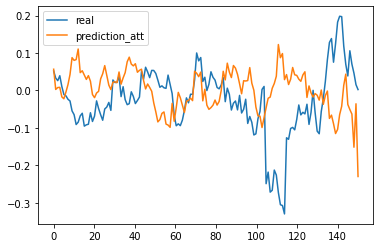

In [7]:
test = table_part.tail(150)['10日回报率']
x = np.linspace(0, len(test), len(test))
#plot
plt.plot(x, test, label='real')
plt.plot(x, pre_att, label='prediction_att')
plt.legend()
plt.show()

In [4]:
a = table_part.tail(150)
a.columns = ['code','Date','Return','Close','High','Low','Open','1','2','Volume','low/high']
a['Return'] = pre_gru
a = a.reset_index()

/tmp/ipykernel_280/485271461.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a['Return'] = pre_gru


In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import timedelta
from matplotlib import style
import plotly.graph_objects as go
import pandas as pd
import yfinance as yf

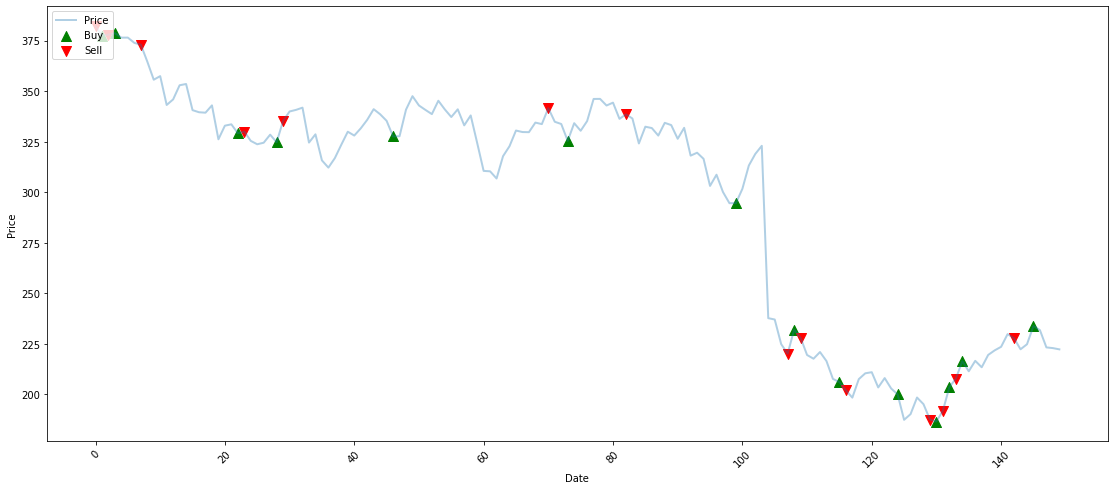

In [11]:
d=pd.DataFrame()
d=a
def buy_sell(data):
    buy=[]
    sell=[]
    flag=-1
    profit = 0
    for i in range(len(data)):
        if data['Return'][i]<0:
            if flag!=1:
                buy.append(data['Close'][i])
                sell.append(np.nan)
                flag=1
            else:
                buy.append(np.nan)
                sell.append(np.nan)

        elif data['Return'][i]>0:
            if flag!=0:
                buy.append(np.nan)
                sell.append(data['Close'][i])
                flag=0
            else:
                buy.append(np.nan)
                sell.append(np.nan)
        else:
            buy.append(np.nan)
            sell.append(np.nan)
            
    return (buy, sell)
a1=buy_sell(d)
d['Buy Signal Price']=a1[0]
d['Sell Signal Price']=a1[1]
plt.figure(figsize=(19,8))
plt.plot(d['Close'],label='Price',linewidth=2, alpha=0.35)
#plt.plot(d['SMA30'],label='SMA30',linewidth=2, alpha=0.35)
#plt.plot(d['SMA100'],label='SMA100',linewidth=2, alpha=0.35)
plt.scatter(d.index, d['Buy Signal Price'], s=100, label='Buy', marker='^', color='green')
plt.scatter(d.index, d['Sell Signal Price'], s=100, label='Sell', marker='v', color='red')
plt.xticks(rotation=45)
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend(loc='upper left')
plt.show()

In [12]:
print('profit:',d['Sell Signal Price'].sum() - d['Buy Signal Price'].sum())

profit: 107.659912109375
